This is the import section

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder 
from sklearn.discriminant_analysis import StandardScaler 
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.compose import ColumnTransformer 
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression


Fetch data frame

In [54]:
df_raw = pd.read_csv("./data/raw_database.csv", dtype={
'Flight Phase':'str', 
'Visibility':'str',
'Precipitation':'str',
'Species ID':'str', 
'Species Name':'str', 
'Species Quantity':'str',
'Flight Impact': 'str', 
'Height':'Int64', 
'Speed':'float64',
'Distance':'float64',  
'Fatalities':'Int64', 
'Injuries': 'Int64'}, low_memory=False) 
df_raw.shape

(174104, 66)

In [55]:
pd.set_option('display.max_columns', None)
df=df_raw.drop(['Record ID','Incident Year','Incident Month','Incident Day','Operator','Airport'], axis=1) 
df.head(2)

,Operator ID,Aircraft,Aircraft Type,Aircraft Make,Aircraft Model,Aircraft Mass,Engine Make,Engine Model,Engines,Engine Type,Engine1 Position,Engine2 Position,Engine3 Position,Engine4 Position,Airport ID,State,FAA Region,Warning Issued,Flight Phase,Visibility,Precipitation,Height,Speed,Distance,Species ID,Species Name,Species Quantity,Flight Impact,Fatalities,Injuries,Aircraft Damage,Radome Strike,Radome Damage,Windshield Strike,Windshield Damage,Nose Strike,Nose Damage,Engine1 Strike,Engine1 Damage,Engine2 Strike,Engine2 Damage,Engine3 Strike,Engine3 Damage,Engine4 Strike,Engine4 Damage,Engine Ingested,Propeller Strike,Propeller Damage,Wing or Rotor Strike,Wing or Rotor Damage,Fuselage Strike,Fuselage Damage,Landing Gear Strike,Landing Gear Damage,Tail Strike,Tail Damage,Lights Strike,Lights Damage,Other Strike,Other Damage
0,DAL,B-757-200,A,148,26,4.0,34.0,40,2.0,D,1,1.0,NaN,NaN,KCVG,KY,ASO,NaN,CLIMB,NaN,NaN,<NA>,NaN,NaN,NE1,GULL,1,NaN,<NA>,<NA>,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,HAL,DC-9,A,583,90,4.0,34.0,10,2.0,D,5,5.0,NaN,NaN,PHLI,HI,AWP,NaN,TAKEOFF RUN,NaN,NaN,0,NaN,0.0,ZZ201,HOUSE SPARROW,1,NaN,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [56]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

1 We need to remove rows where there is no animal invoved or where the species ID and the species name is not known.

2 From these 66 columns, we are going to select only few of them that are necessary for the prediction. 

In [57]:
no_of_null_id= df[df['Species ID'].isnull()]['Species ID'].count()
no_of_null_name = df[df['Species Name'].isnull()]['Species ID'].count()
print(f"Number of null ID {no_of_null_id} and Name {no_of_null_name}")

Number of null ID 0 and Name 80


In [58]:
#Checking what ID was given for names  
df[df['Species Name'].isnull()]['Species ID'].unique()
#species_map = df_raw.dropna(subset=["Species Name"]).set_index("Species ID")["Species Name"].to_dict()
#df_raw["Species Name"] = df_raw.apply(lambda row: species_map.get(row["Species ID"], row["Species Name"]), axis=1)
#print(df_raw["Species Name"].isnull().sum())
#mismatched = df_raw[df_raw["Species Name"] != df_raw["Species ID"].map(species_map)] 

array(['UNK'], dtype=object)

In [59]:
df[df['Species ID'].str.startswith('UNK')].groupby(['Species Name']).count()
no_of_rows_unknown_name = df[df['Species ID'].str.startswith('UNK')]['Species ID'].count() 
print(f"Number of unknown animals {no_of_rows_unknown_name}.") 

Number of unknown animals 80851.


In [60]:
df = df[~df['Species ID'].str.startswith('UNK')]
df.shape

(93253, 60)

In [61]:
distinct_values = {col: df[col].unique().tolist() for col in categorical_cols}

# Display the dictionary
for col, values in distinct_values.items():
    if(col == 'Species ID' or col == 'Species Name'):
        continue
    print(f"{col}: {values}")

Operator ID: ['DAL', 'HAL', 'UNK', 'MIL', 'USA', 'BUS', 'SWA', 'PVT', 'UPS', 'USC', 'AAH', 'DLH', 'NHK', 'UAL', 'AAL', 'ANA', 'LOF', 'USCG', 'EAL', 'COA', 'UNKC', 'BAW', 'DHL', 'JIA', 'BRG', 'SVA', 'MES', '1AWE', 'BVN', 'COM', 'EWW', '1AAH', 'ELY', 'MDW', 'GAA', 'AMT', '1ASQ', 'SDU', 'NCC', 'HNA', 'CDL', 'CHQ', 'TWA', 'AMW', 'AJC', 'EGF', 'SKW', 'MEP', 'FDX', 'CFS', 'PHM', 'BTA', 'VGA', 'PDT', 'QXE', 'ASA', 'NWA', 'ASH', 'LHN', 'GOV', 'SYM', 'BSY', 'FXA', 'RBD', 'NAE', 'MRK', 'OAL', 'PJE', 'FSX', 'AWI', 'PAA', 'CDN', 'MTR', 'AXQ', 'PXX', 'SRV', 'MDC', 'CAL', 'WWM', 'JAL', 'ALO', 'TCN', 'FLG*', 'AMF', 'ACK', 'KFS', 'ACA', 'NRS', 'GPE', 'FLX', 'HAR', 'EME', 'CAY', 'HKA', 'EXA', 'CPT', 'HTC', 'RGS', 'RLT', 'ALG', 'ANZ', 'XAP', 'USX', 'AJM', 'MTN', 'CRO', 'PAH', 'TPY', 'BLR', 'AFR', 'ASI', 'CTL', 'EPS', 'CKT', 'GLA', 'EJM', 'WSA', 'FST', 'ABX', 'SIP', 'DOJ', 'UCA', 'PRE', 'REX', 'SPA', 'RFA', 'REC', 'CWC', 'CKE', 'BKA', 'BOE', 'SKX', 'PMS', 'KAL', 'SYX', 'UFS', 'CBM', 'CJC', 'RMA', 'MCN', 

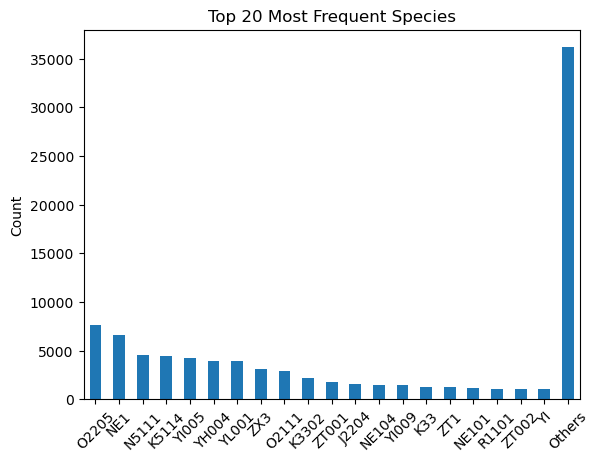

In [62]:
# Count occurrences of each species
species_counts = df['Species ID'].value_counts()
top_n = 20
top_species = species_counts.head(top_n)
other_species = pd.Series(species_counts.iloc[top_n:].sum(), index=['Others'])

# Combine the top species with the "Others" category
plot_data = pd.concat([top_species, other_species])
 
plot_data.plot(kind='bar')
plt.title(f'Top {top_n} Most Frequent Species')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()


Checking the correlation of variables.

In [63]:
cols_to_encode = [
    'Operator ID', 'Aircraft', 'Aircraft Type', 'State',
    'Aircraft Make', 'Aircraft Model', 'Engine Model', 'Engine Type',
    'Engine1 Position', 'Engine3 Position', 'Airport ID', 
    'FAA Region', 'Warning Issued', 'Flight Phase', 'Visibility',
    'Precipitation', 'Species Quantity','Species Name','Species ID',
    'Flight Impact'
]
#df=df_raw.copy()
X = df.copy()
X= X.drop(['Fatalities','Injuries'],axis=1) 

species_counts = X['Species Name'].value_counts()
species_to_drop = species_counts[species_counts > 5].index
X = X[~((X['Species Name'].isna()) & (X['Species Name'].isin(species_to_drop)))]

# Fill missing values in numerical columns with the median
X[cols_to_encode] = X[cols_to_encode].fillna(X[cols_to_encode].mode()) 
X = X.dropna(subset=['Species Name'], axis=0)
#For categorical data filling with the most frequent value (mode)
for col in numerical_cols:
    if(col == 'Fatalities' or col == 'Injuries'):
        continue
    X[col] = X[col].fillna(X[col].median())
   

encoder = TargetEncoder() 
X[cols_to_encode] = encoder.fit_transform(X[cols_to_encode],X['Species Name'])
corr_matrix = X.corr() 

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.7)]

print("Highly correlated features to consider dropping:", to_drop)

X_reduced = X.drop(columns=to_drop)


Highly correlated features to consider dropping: ['Engine Type', 'Engine1 Position', 'State', 'Species Name', 'Lights Damage']


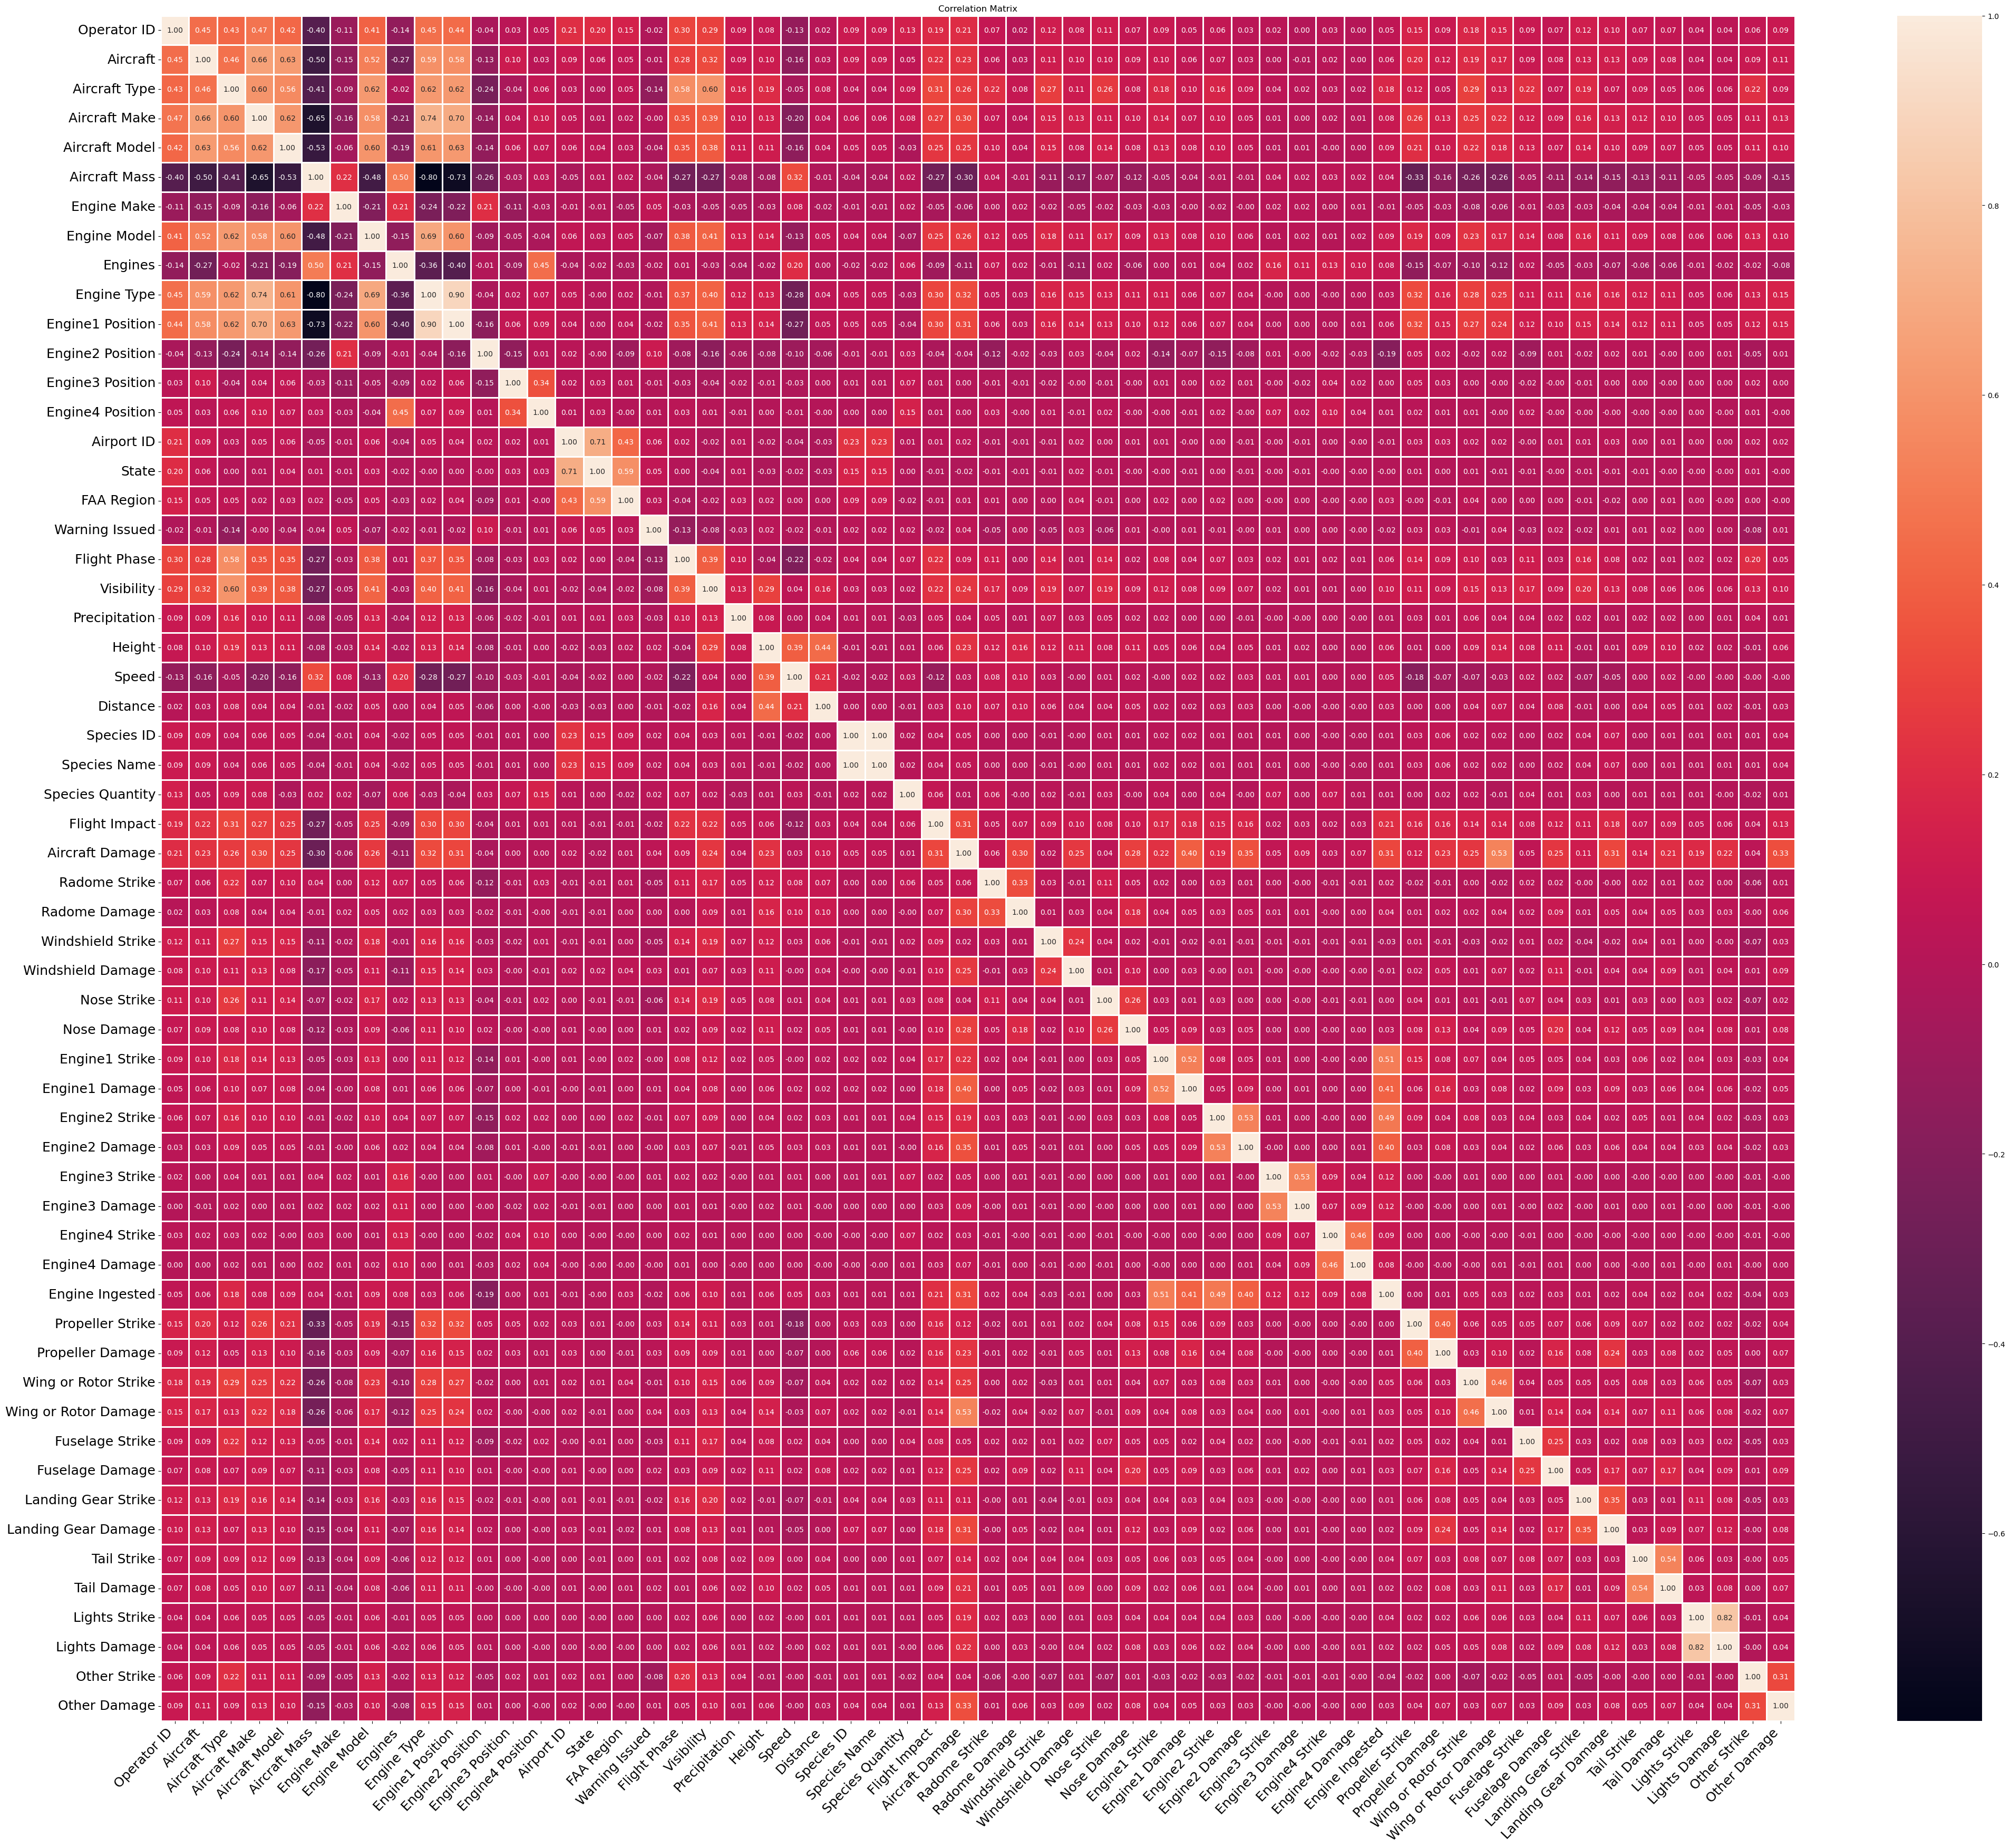

In [64]:
#corr_matrix = X.iloc[:,4:].corr(numeric_only=True)
plt.figure(figsize=(50, 42))
sns.heatmap(corr_matrix, annot=True,fmt='.2f', linewidths=2,annot_kws={"size": 10}) 
plt.title("Correlation Matrix")
plt.xticks(fontsize=18, rotation=46, ha='right')
plt.yticks(fontsize=18, rotation=0)
plt.show()

Removing species or class category in other word that has only 10 or less occurence

In [65]:
d = df['Species Name'].value_counts()
species_to_drop = d[d < 10].groupby(['Species Name']).count()
species_to_drop

Species Name
ACADIAN FLYCATCHER           1
ALLEN'S HUMMINGBIRD          1
ALLIGATOR SNAPPING TURTLE    1
AMERICAN AVOCET              1
AMERICAN BLACK BEAR          1
                            ..
YELLOW-HEADED CARCARA        1
YELLOW-LEGGED GULL           1
YELLOW-THROATED VIREO        1
YUMA MYOTIS                  1
ZENAIDA DOVE                 1
Name: count, Length: 351, dtype: int64

In [66]:
d = df['Species Name'].value_counts()
species_to_drop = d[d < 10].index
df = df[~df['Species Name'].isin(species_to_drop)]  
df.shape

(92154, 60)

Spliting train and test

In [67]:
# Sample N rows per class (or all if less than N)
sampled_df = pd.concat([
    df_class.sample(n=min(len(df_class), 100), random_state=42)
    for _, df_class in df.groupby('Species Name')
])

species_counts = sampled_df['Species Name'].value_counts()
species_with_enough_data = species_counts[species_counts >= 5].index

df_filtered = sampled_df[sampled_df['Species Name'].isin(species_with_enough_data)]

X = df_filtered.drop(['Species Name', 'Species ID'], axis=1)
y = df_filtered['Species Name']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)


Imputation
Using Mode for categorical and Median for the numerical

In [74]:
X_train[numerical_cols] = X_train[numerical_cols].astype('float').fillna(X_train[numerical_cols].median())

for col in categorical_cols:
    if(col == 'Species Name' or col == 'Species ID'):
        continue
    X_train[col] = X_train[col].fillna(X_train[col].mode()[0]) 

In [73]:
X_test[numerical_cols] = X_test[numerical_cols].astype('float').fillna(X_test[numerical_cols].median())

for col in categorical_cols:
    if(col == 'Species Name' or col == 'Species ID'):
        continue
    X_test[col] = X_test[col].fillna(X_test[col].mode()[0]) 

Encode Features

In [76]:
cols_to_encode = [
    'Operator ID', 'Aircraft', 'Aircraft Type', 'State',
    'Aircraft Make', 'Aircraft Model', 'Engine Model', 'Engine Type',
    'Engine1 Position', 'Engine3 Position', 'Airport ID', 
    'FAA Region', 'Warning Issued', 'Flight Phase', 'Visibility',
    'Precipitation', 'Species Quantity',
    'Flight Impact'
]
encoder = TargetEncoder()
X_train[cols_to_encode] = encoder.fit_transform(X_train[cols_to_encode], y_train)
X_test[cols_to_encode] = encoder.transform(X_test[cols_to_encode])

SMOTE

In [78]:
smote = SMOTE(random_state=42, k_neighbors=2)
X_train, y_train = smote.fit_resample(X_train.astype(float), y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [ ]:
pipeline = Pipeline([ 
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver='saga', max_iter=2000,random_state=42))
])
#('pca', PCA(n_components=0.95)),
#('model', RandomForestClassifier(random_state=42))
#param_grid = {
#    'model__n_estimators': [100],
#    'model__max_depth': [10],
#    'model__min_samples_split': [2]
#}
param_grid = {'model__C': np.logspace(0.1, 3, 10)}
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro',
                    n_jobs=-1, verbose=1, return_train_score=True)
 

grid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max

KeyboardInterrupt: 

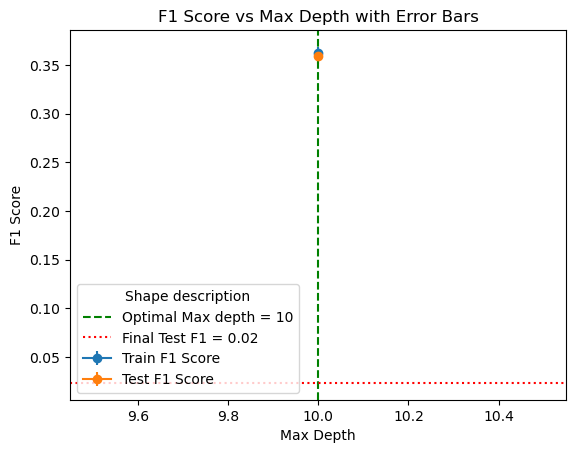

In [141]:
result=grid.cv_results_  
y_pred_test = grid.best_estimator_.predict(X_test)
final_test_score = f1_score(y_test, y_pred_test, average='macro')
def draw_error(max_depths,mean_train_scores,std_train_scores,mean_test_scores,std_test_scores,optimal_max_depth,final_test_score):
    plt.errorbar(max_depths, mean_train_scores, yerr=std_train_scores, label="Train F1 Score", fmt='-o')
    plt.errorbar(max_depths, mean_test_scores, yerr=std_test_scores, label="Test F1 Score", fmt='-o')

    plt.axvline(optimal_max_depth, color='green', linestyle='--', label=f'Optimal Max depth = {optimal_max_depth}')
    plt.axhline(final_test_score, color='red', linestyle=':', label=f'Final Test F1 = {final_test_score:.2f}')

    plt.xlabel("Max Depth")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs Max Depth with Error Bars")
    plt.legend(loc="lower left", title="Shape description") 
    plt.show()


draw_error(result['param_model__max_depth'],result['mean_train_score'],
           result['std_train_score'],result['mean_test_score'],
           result['std_test_score'],grid.best_params_['model__max_depth'],final_test_score )


In [ ]:
acc = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test, average='weighted')

print("Best Model Params:", grid.best_params_)
print("Accuracy:", acc)
print("F1 Score:", f1)

Best Model Params: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Accuracy: 0.0336932342249471
F1 Score: 0.02334629614967282
